<a href="https://colab.research.google.com/github/YuLiu83/Practical-business-case-code-demo/blob/main/BERT_with_Tensorflow_2_3_(Keras).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The task is to create a text classification model predicting whether an email is spam by using state-of-the-art NLP module BERT with the newest Tensorflow 2.3 API. Even with minimal fine-tunes, the model outperforms the bi-directional LSTM model shown in other work samples. 

The approach is new by running the pre-trained Bert model in Keras style as since Tensorflow 2.0 Keras has been adapted into Tensorflow, and it becomes the mostly encouraged approach to build ML models by the Tensorflow support team.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Enviroment Install

In [ ]:
# pip install --upgrade tensorflow==2.3
# pip install -q tf-nightly-gpu avoid this package as it actually shuts down gpu on colab

In [ ]:
pip install tf-models-official

     |████████████████████████████████| 849kB 2.9MB/s 
     |████████████████████████████████| 174kB 15.7MB/s 
     |████████████████████████████████| 36.6MB 80kB/s 
     |████████████████████████████████| 358kB 57.9MB/s 
     |████████████████████████████████| 102kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=a6f7fb713db59b89f77c71acf1e2d833a126ac9581f9bbeef36c4296aa8648a2
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.5-cp36-none-any.whl size=30317 sha256=bf4068407e67dcb5907258a082bcde21c0b6822b5c820da8112844a47384481e
  Stored in directory: /root/.cache/pip/wheels/2e/70/a2/be357037dd2cbdcaeb0add1fdf083be6a600ca65ee1f68751c
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=55b886f64b20b0b131dd081c9a7a491ee21d05f34a52227a30bc631dbcf1ad3b
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=16ad95632e6094cf5ddeb01d73b745380033e53e5654d528b05f2445dd1c7633
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from bert import bert_tokenization
#FullTokenizer = bert_tokenization.FullTokenizer
from tensorflow.keras.models import Model       # Keras is the new high level API for TensorFlow
import math

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks



In [ ]:
# Download keras bert module

gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [ ]:
# download the configuration for the pre-trained model.

import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

Max word embedding dimension supported by this pre-trained model is 512, any document longer than 512 needs to be truncated.

### Data Processing

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# load the saved combined file
import pickle

with open('/content/drive/My Drive/dataset.data', 'rb') as file:
    # read the data as binary data stream
    dataset = pickle.load(file)

type(dataset)

list

In [ ]:
# Though not necessary into a dataframe, doing so just for easier data manipulation when needed
from pandas import DataFrame
Data=DataFrame(dataset, columns=['Label', 'Text'])
Data.head()

,Label,Text
0,1,"Subject: re : account # 69627 u\nhello ,\nwe s..."
1,1,Subject: get your free viagra\nalways wanted t...
2,1,Subject: epson inkjet cartridges from 5 . 99\n...
3,1,Subject: again adobe photoshop ; xp pro ( sp 2...
4,1,Subject: meet ppl in your area !\n100 % free a...


In [ ]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


Test out tokenizer and text length

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

sentence = tf.ragged.constant([
    encode_sentence(s) for s in Data["Text"]])

In [ ]:
# check document length
from pandas import DataFrame
DataFrame([len(sentence[i]) for i in range(sentence.shape[0])]).describe()

,0
count,5999.000000
mean,339.261044
std,430.472111
min,4.000000
25%,95.000000
50%,185.000000
75%,396.000000
max,5994.000000


Majority documents are less than 400 tokens, max_position_embeddings from pre-trained model configuraton is sufficient. For speed of processing 200 is choosen.

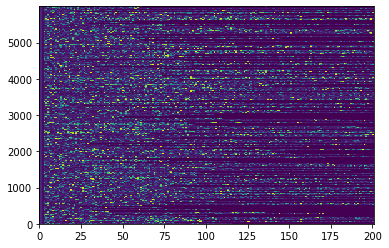

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence[:,:200].shape[0]
input_word_ids = tf.concat([cls, sentence[: ,:200]], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

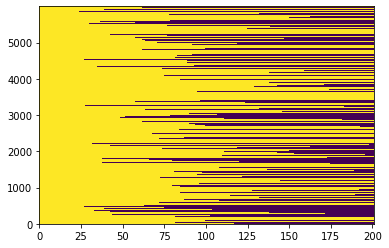

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

Data Processing

In [ ]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(input, tokenizer):
  num_examples = len(input)
  
  sentence = tf.ragged.constant([
      encode_sentence(s)
      for s in input])
  
# minor flaw: truncate long text this way lose ['SEP'], an option in tokenizer may fix this (or done manually)
# however the foucs of classification tasks is only on ['CLS']
  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence[:, :200].shape[0]
  input_word_ids = tf.concat([cls, sentence[:, :200]], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s = tf.zeros_like(sentence[: , :200])

  input_type_ids = tf.concat(
      [type_cls, type_s], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
# Split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(Data['Text'], Data['Label'], test_size = 0.20, random_state=80)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state=80)



In [ ]:
Text_train = bert_encode(X_train, tokenizer)
Label_train = Y_train

Text_val = bert_encode(X_val, tokenizer)
Label_val = Y_val

Text_test = bert_encode(X_test, tokenizer)
Label_test = Y_test


In [ ]:
for key, value in Text_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'Label shape: {Label_train.shape}')

input_word_ids  shape: (3839, 201)
input_mask      shape: (3839, 201)
input_type_ids  shape: (3839, 201)
Label shape: (3839,)


### Modeling & Evaluation

Setting up model structure

In [ ]:
bert_classifier, bert_encoder =bert.bert_models.classifier_model(bert_config, num_labels=2)

The model will be built with default bert classifier settings for both the transformer layer and the fine tune layer, i.e. bert layer output + a dense layer for classification. Customization can be done on the fine tune layer if more complex model is desired.

In [ ]:
bert_classifier.summary()

Model: "bert_classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_encoder (Transforme [(None, None, 768),  109482240   input_word_ids[0][0]             
                                                                 input_mask[0][0]   

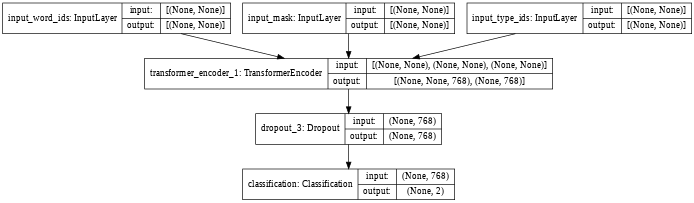

In [ ]:
# Classifier structure
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

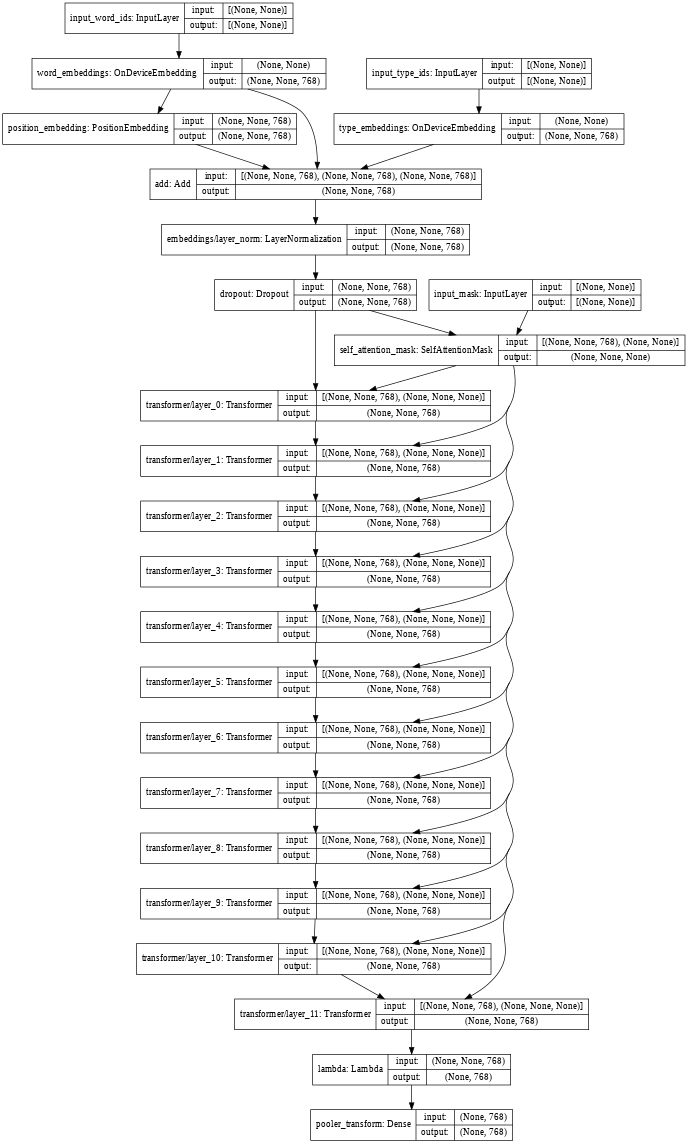

In [ ]:
# Bert encoder structure
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [ ]:
# import pre-trained model structure from the check point file
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

In [ ]:
# Optimizer

# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(Label_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
# convert response lists into tensors
Label_train=tf.convert_to_tensor(Label_train)
Label_val=tf.convert_to_tensor(Label_val)
Label_test=tf.convert_to_tensor(Label_test)

In [ ]:
# making sure gpu is indeed available before training starts
print(tf.test.gpu_device_name())
tf.test.is_gpu_available()

/device:GPU:0


True

In [ ]:
# Start training

metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      Text_train, Label_train,
      validation_data=(Text_val, Label_val),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
120/120 [==============================] - ETA: 0s - loss: 0.0058 - accuracy: 0.9987WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0076s vs `on_test_batch_end` time: 0.1213s). Check your callbacks.


120/120 [==============================] - 53s 442ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.0250 - val_accuracy: 0.9958
Epoch 2/3
120/120 [==============================] - 52s 434ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0308 - val_accuracy: 0.9906
Epoch 3/3
120/120 [==============================] - 52s 434ms/step - loss: 3.9854e-04 - accuracy: 1.0000 - val_loss: 0.0245 - val_accuracy: 0.9917


Even with only 3 epoches, the model performance is amazing. Compareing to LSTM models used on same data, the process is much faster and results are much more accurate even the data is unbalanced (1:3 between two classes)

In [ ]:
# Same the model
bert_classifier.save('/content/drive/My Drive/Checkpoints')


In [ ]:
# Load the model
bert_classifier = keras.models.load_model('path/to/location')

In [ ]:
# Evaluate model performance on test data
bert_classifier.evaluate(Text_test, Label_test)

38/38 [==============================] - 5s 128ms/step - loss: 0.0222 - accuracy: 0.9933


[0.02223675325512886, 0.9933333396911621]

The model performance on un-seen test data achieves >99% accuracy.